In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.measure import compare_ssim
from os import listdir, path
from tempfile import TemporaryFile
import pymysql

%matplotlib inline

In [2]:
import pymysql


def connect_db(sql,action):
    
    r=[]
    if action == "u":
        cursor.execute(sql)
        db.commit()
    if action == "s":
        cursor.execute(sql)
        results = cursor.fetchall()
        for row in results:
            r.append(row)
        return r

db = pymysql.connect("localhost","Sebrm","sebrm","Rumbomobile")
cursor = db.cursor()


In [3]:
def obtain_pklots(entry,coords,coordsX,coordsY):
    masks = []
    image = entry
    for i in range(len(coords)):
        ROI_corners = np.array([coords[i].tolist()], dtype=np.int32) 
        mask = np.zeros(image.shape, dtype=np.uint8)
        cv2.fillPoly(mask, ROI_corners, (255))
        masked_image = cv2.bitwise_and(image, mask)
        masked_image = masked_image[np.min(coordsY[i]):np.max(coordsY[i]),np.min(coordsX[i]):np.max(coordsX[i])]
        masks.append(masked_image)
    return masks

In [4]:
def read_images(path):
    img_list   = {}
    img_clist  = {}
    files_imgs = sorted(listdir(path))
    cont       = 0
#     print(files_imgs)
    for i in files_imgs:
        img_clist[str(cont)] = cv2.imread(path+'/'+i,cv2.IMREAD_COLOR)
        img_list[str(cont)] = cv2.imread(path+'/'+i,cv2.IMREAD_GRAYSCALE)
        cont = cont + 1
    
    return [img_list,img_clist]

In [5]:
def compare(pklot_empty,pklot_ref,pklot_new,state_old):
    scores     = []
    scores_emp = []
    bck_diff   = []
    stat       = []
    for i in range(len(pklot_ref)): 
        
        img_emp = pklot_empty[i]
        img_A   = pklot_ref[i]
        img_B   = pklot_new[i]

        bck_diff.append(img_B-img_A)

        
        (score_emp,_) = compare_ssim(img_emp, img_B, full=True)
        (score,_)     = compare_ssim(img_A, img_B, full=True)
        score         = np.float32(score)
        
        scores.append(score)
        scores_emp.append(score_emp)
        
        if score > 0.65 :
            stat.append(state_old[i])
        else:
            
            if state_old[i] == "occupied":
                if score_emp < 0.6:
                    stat.append("occupied")
                else:
                    stat.append("empty")
            else:
                stat.append("occupied")
                
    
    
    return [scores_emp,scores,stat]

In [18]:
def show_pklots(img_color,coords,state):
    img_color = cv2.cvtColor(img_color,cv2.COLOR_BGR2RGB)
    
    for i in range(len(coords)):
        if state[i] == "empty":
            color = (0,255,0)
        else:
            color = (255,0,0)
        cv2.line(img_color, coords[i][3], coords[i][0], color, thickness=2, lineType=8, shift=0)
        cv2.line(img_color, coords[i][0], coords[i][1], color, thickness=2, lineType=8, shift=0)
        cv2.line(img_color, coords[i][1], coords[i][2], color, thickness=2, lineType=8, shift=0)
        cv2.line(img_color, coords[i][2], coords[i][3], color, thickness=2, lineType=8, shift=0)
        font = cv2.FONT_HERSHEY_SIMPLEX

#         cv2.putText(img_color,str(i),coords[i][0], font, 1,color,2,cv2.LINE_AA)

    plt.figure(figsize=(16,16))
    plt.imshow(img_color)
    plt.show()

In [7]:
def enum_pklot(img_color):
    img_color = cv2.cvtColor(img_color,cv2.COLOR_BGR2RGB)
    
    for i in range(len(coords)-14):
        font = cv2.FONT_HERSHEY_SIMPLEX

        cv2.putText(img_color,str(i),coords[i][0], font, 0.4,(0,0,255),1,cv2.LINE_AA)

    plt.figure(figsize=(16,16))
    plt.imshow(img_color)
    plt.show()

In [8]:
sql = "SELECT * FROM virtualpklot1"
data = connect_db(sql,"s")
len(data)

182

In [9]:
coordsX=[]
b=[coordsX.append(data[i][1].split(",")) for i in range(len(data))]
coordsY=[]
b=[coordsY.append(data[i][2].split(",")) for i in range(len(data))]

coordsX = np.float32(coordsX)
coordsY = np.float32(coordsY)
coords = np.zeros(coordsX.shape,dtype = tuple)
coords_mag = np.sqrt(coordsX**2 + coordsY**2)
coords_mag.sort()
minmag = coords_mag[:,0]
maxmag = coords_mag[:,3]

for i in range(len(coordsX)):
    k = 1
    for j in range(len(coordsX[1])):
        
        if (np.abs(np.sqrt(coordsX[i][j]**2 + coordsY[i][j]**2) - minmag[i]) <=0.01):
            coords[i][0]=(coordsX[i][j],coordsY[i][j])
        elif (np.abs(np.sqrt(coordsX[i][j]**2 + coordsY[i][j]**2) - maxmag[i]) <=0.01):
            coords[i][2]=(coordsX[i][j],coordsY[i][j])
        else:
            coords[i][k]=(coordsX[i][j],coordsY[i][j])
            k = k + 2
        
            
coords.tolist();
coordsX = np.uint16(coordsX)
coordsY = np.uint16(coordsY)

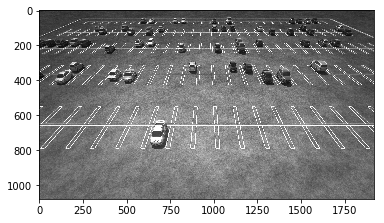

In [9]:
imgs,imgsc = read_images("alpha_test/moments")
plt.imshow(imgs["0"],cmap="gray")
plt.show()

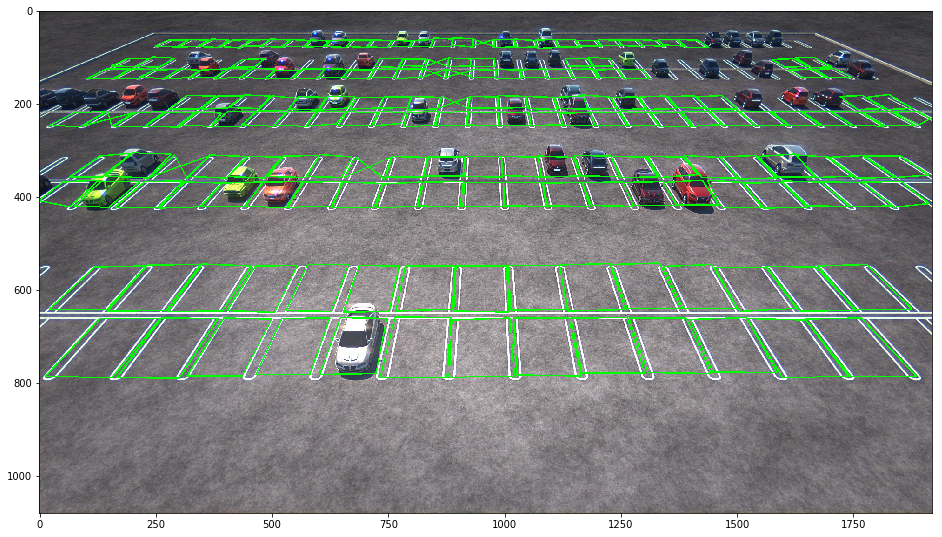

In [19]:
img = cv2.imread('alpha_test/Moment_0.jpg',cv2.IMREAD_GRAYSCALE)

coords = np.load("coords.npy")
coordsX = np.load("coordsX.npy")
coordsY = np.load("coordsY.npy")
coordsX = np.uint16(coordsX)
coordsY = np.uint16(coordsY)


pklot_empty = obtain_pklots(img,coords,coordsX,coordsY)
pklot_new = obtain_pklots(imgs["0"],coords,coordsX,coordsY)
state = []
comp = []
ms = []
bck_diff = []



for i in range(len(pklot_empty)): 

    img_A = pklot_empty[i]
    img_B = pklot_new[i]
    
    bck_diff.append(img_B-img_A)
    
    (score, diff) = compare_ssim(img_A, img_B, full=True)
    comp.append(score)
    
comp = np.float32(comp)
# print(compare)
meh2= (comp>0.5)
# print(compare)
# print(meh2)
old_state = []
for i in range(len(meh2)):
    if meh2[i]:
        old_state.append("empty")
    else:
        old_state.append("occupied")
        
pklot_old = pklot_new
state.append(old_state)
show_pklots(imgsc["0"],coords,state[0])

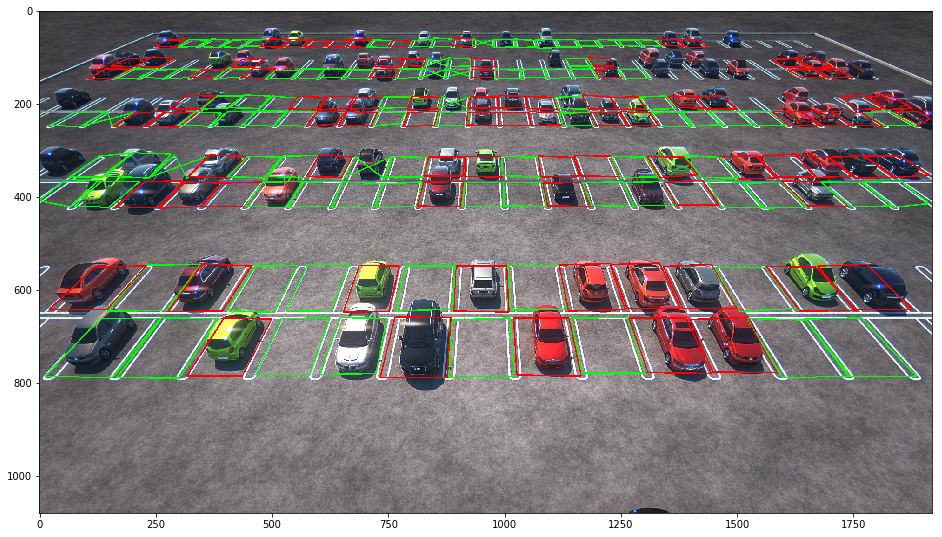

In [12]:
ind = 1
# for i in range(10):
pklot_old = obtain_pklots(imgs[str(ind-1)],coords,coordsX,coordsY)
pklot_new = obtain_pklots(imgs[str(ind)],coords,coordsX,coordsY)
comp_e,comp,temp = compare(pklot_empty,pklot_old,pklot_new,state[ind-1])
state.append(temp)
# state[ind] = temp
show_pklots(imgsc[str(ind)],coords,state[ind])

In [31]:
len(coordsX)

72

In [33]:
print(comp[22])
print(comp_e[22])

0.5385039
0.5385038841270546


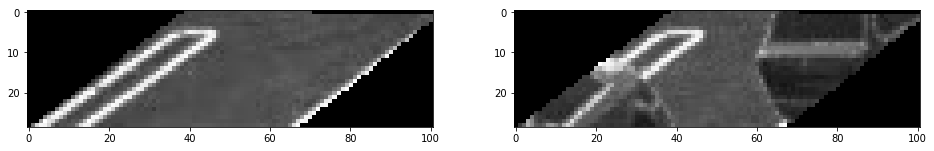

In [32]:
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(pklot_old[22],cmap="gray")
plt.subplot(1,2,2)
plt.imshow(pklot_new[22],cmap="gray")
plt.show()

In [100]:
coordsX=[]
b=[coordsX.append(data[i][1].split(",")) for i in range(len(data))]
coordsY=[]
b=[coordsY.append(data[i][2].split(",")) for i in range(len(data))]

coordsX = np.float32(coordsX)
coordsY = np.float32(coordsY)
coords = np.zeros(coordsX.shape,dtype = tuple)
coords_mag = np.sqrt(coordsX**2 + coordsY**2)
coords_mag.sort()
minmag = coords_mag[:,0]
maxmag = coords_mag[:,3]

for i in range(len(coordsX)):
    k = 1
    for j in range(len(coordsX[1])):
        
        if (np.abs(np.sqrt(coordsX[i][j]**2 + coordsY[i][j]**2) - minmag[i]) <=0.01):
            coords[i][0]=(coordsX[i][j],coordsY[i][j])
        elif (np.abs(np.sqrt(coordsX[i][j]**2 + coordsY[i][j]**2) - maxmag[i]) <=0.01):
            coords[i][2]=(coordsX[i][j],coordsY[i][j])
        else:
            coords[i][k]=(coordsX[i][j],coordsY[i][j])
            k = k + 2
        
            
coords.tolist();
coordsX = np.uint16(coordsX)
coordsY = np.uint16(coordsY)

In [109]:
coords_mag[25]

array([425.91315, 430.44745, 481.0873 , 481.69803], dtype=float32)

In [111]:
coordsY[25][2]

312

In [110]:
coordsX[25]
np.sqrt(coordsX[25][2]**2 + coordsY[25][2]**2)

481.6980381940537

In [12]:
coords = np.load("coords.npy")
print(coords)

[[(249.0, 77.0) (277.0, 64.0) (320.0, 64.0) (296.0, 79.0)]
 [(299.0, 79.0) (322.0, 63.0) (364.0, 64.0) (340.0, 78.0)]
 [(344.0, 78.0) (371.0, 62.0) (408.0, 64.0) (385.0, 80.0)]
 [(391.0, 78.0) (416.0, 64.0) (453.0, 63.0) (432.0, 81.0)]
 [(437.0, 77.0) (455.0, 64.0) (496.0, 63.0) (475.0, 77.0)]
 [(475.0, 78.0) (522.0, 79.0) (540.0, 64.0) (498.0, 62.0)]
 [(521.0, 78.0) (569.0, 78.0) (581.0, 65.0) (541.0, 63.0)]
 [(571.0, 79.0) (611.0, 78.0) (623.0, 66.0) (584.0, 64.0)]
 [(617.0, 78.0) (659.0, 80.0) (671.0, 64.0) (626.0, 65.0)]
 [(660.0, 78.0) (704.0, 80.0) (715.0, 64.0) (672.0, 64.0)]
 [(704.0, 79.0) (749.0, 80.0) (759.0, 65.0) (717.0, 64.0)]
 [(751.0, 78.0) (795.0, 78.0) (804.0, 66.0) (760.0, 65.0)]
 [(796.0, 78.0) (840.0, 78.0) (846.0, 63.0) (802.0, 65.0)]
 [(843.0, 78.0) (887.0, 78.0) (890.0, 62.0) (848.0, 60.0)]
 [(886.0, 75.0) (889.0, 60.0) (934.0, 61.0) (932.0, 79.0)]
 [(931.0, 77.0) (977.0, 63.0) (978.0, 78.0) (933.0, 62.0)]
 [(978.0, 63.0) (978.0, 80.0) (1024.0, 79.0) (1020.0, 63

In [ ]:
    img_color = cv2.cvtColor(img_color,cv2.COLOR_BGR2RGB)
    
    for i in range(len(coords)):
        if state[i] == "empty":
            color = (0,255,0)
        else:
            color = (255,0,0)
#         cv2.line(img_color, coords[i][3], coords[i][0], color, thickness=2, lineType=8, shift=0)
#         cv2.line(img_color, coords[i][0], coords[i][1], color, thickness=2, lineType=8, shift=0)
#         cv2.line(img_color, coords[i][1], coords[i][2], color, thickness=2, lineType=8, shift=0)
#         cv2.line(img_color, coords[i][2], coords[i][3], color, thickness=2, lineType=8, shift=0)
        font = cv2.FONT_HERSHEY_SIMPLEX

        cv2.putText(img_color,str(i),coords[i][0], font, 1,color,2,cv2.LINE_AA)

    plt.figure(figsize=(16,16))
    plt.imshow(img_color)
    plt.show()